# Profiling ubersum with different plate sizes

In [1]:
from __future__ import absolute_import, division, print_function

import argparse
import timeit

import torch
from matplotlib import pyplot
from pyro.ops.contract import ubersum

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
_CACHE = {}

def jit_ubersum(equation, *operands, **kwargs):

    key = equation, kwargs['batch_dims']
    if key not in _CACHE:

        def _ubersum(*operands):
            return ubersum(equation, *operands, **kwargs)

        fn = torch.jit.trace(_ubersum, operands, check_trace=False)
        _CACHE[key] = fn

    return _CACHE[key](*operands)

In [3]:
def time_ubersum(equation, *operands, **kwargs):
    iters = kwargs.pop('iters')
    jit_ubersum(equation, *operands, **kwargs)
    time = -timeit.default_timer()
    for i in range(iters):
        jit_ubersum(equation, *operands, **kwargs)
    time += timeit.default_timer()
    return time / iters

In [4]:
args = type('Args', (), {})
args.equation = "a,abi,bcij,adj,deij->"
args.batch_dims = "ij"
args.dim_size = 32
args.max_plate_size = 200
args.iters = 100

In [5]:
equation = args.equation
batch_dims = args.batch_dims
inputs, outputs = equation.split('->')
inputs = inputs.split(',')

dim_size = args.dim_size
times = {}
for plate_size in reversed(range(8, 1 + args.max_plate_size, 8)):
    operands = []
    for dims in inputs:
        shape = torch.Size([plate_size if d in batch_dims else dim_size
                            for d in dims])
        operands.append(torch.randn(shape))

    time = time_ubersum(equation, *operands, batch_dims=batch_dims, iters=args.iters)
    times[plate_size] = time
    print('{}\t{}'.format(plate_size, time))

200	0.0049011516571
192	0.00626856088638
184	0.00574758052826
176	0.00526169061661
168	0.00481548070908
160	0.00433192968369
152	0.00391463041306
144	0.00350885152817
136	0.00314826965332
128	0.00277736902237
120	0.00246248960495
112	0.00216462850571
104	0.00189119100571
96	0.00163445949554
88	0.00139925956726
80	0.00117299079895
72	0.000974261760712
64	0.000824630260468
56	0.000773429870605
48	0.000743689537048
40	0.000761728286743
32	0.000738568305969
24	0.000732588768005
16	0.000734329223633
8	0.00073557138443


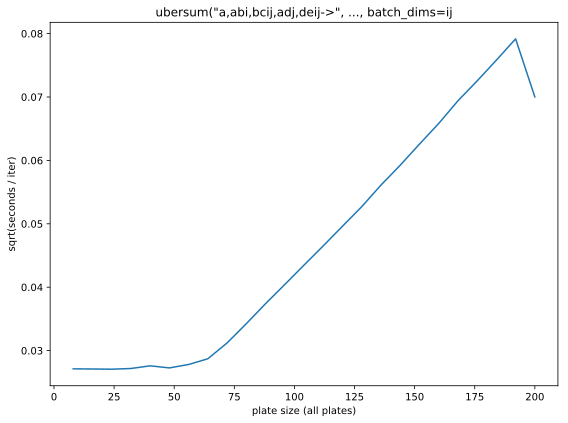

In [6]:
X = sorted(times.keys())
Y = [times[t] ** 0.5 for t in X]
pyplot.figure(figsize=(8,6)).patch.set_color('white')
pyplot.plot(X, Y)
pyplot.title('ubersum("{}", ..., batch_dims={}'.format(args.equation, args.batch_dims))
pyplot.ylabel('sqrt(seconds / iter)')
pyplot.xlabel('plate size (all plates)')
pyplot.tight_layout()